In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import numpy as np
import nibabel as nib
import os
import matplotlib.pyplot as plt

In [5]:
#Define the base paths for images and segmentations
images_dir = "/home/ec2-user/BraTS_ML_Project/data/UPenn_GBM/images"
segs_dir = "/home/ec2-user/BraTS_ML_Project/data/UPenn_GBM/segmentations"

# List all patient folders (each folder represents one patient)
patient_ids = [folder for folder in os.listdir(images_dir) if os.path.isdir(os.path.join(images_dir, folder))]
print("Total patient folders found:", len(patient_ids))

# Verify one example patient folder
example_patient = patient_ids[0]
print("Example patient folder:", example_patient)
print("Files in example image folder:", os.listdir(os.path.join(images_dir, example_patient)))
print("Files in example segmentation folder:", os.listdir(os.path.join(segs_dir, example_patient)))

Total patient folders found: 611
Example patient folder: UPENN-GBM-00001_11
Files in example image folder: ['UPENN-GBM-00001_11_FLAIR.nii.gz', 'UPENN-GBM-00001_11_T1.nii.gz', 'UPENN-GBM-00001_11_T1GD.nii.gz', 'UPENN-GBM-00001_11_T2.nii.gz']
Files in example segmentation folder: ['UPENN-GBM-00001_11_automated_approx_segm.nii.gz']


In [6]:
from sklearn.model_selection import train_test_split

# Use all patient IDs from the previous step
all_patient_ids = patient_ids  
print("Total patients:", len(all_patient_ids))

# First split: 80% for training, 20% for temporary (to be split into val and test)
train_ids, temp_ids = train_test_split(all_patient_ids, test_size=0.2, random_state=42)

# Second split: Split the temporary set equally into validation and test (10% each of total)
val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=42)

print("Training patients:", len(train_ids))
print("Validation patients:", len(val_ids))
print("Testing patients:", len(test_ids))

Total patients: 611
Training patients: 488
Validation patients: 61
Testing patients: 62


In [13]:
import nibabel as nib
import numpy as np
from torch.utils.data import Dataset

class MRIDataset(Dataset):
    def __init__(self, patient_ids, images_dir, segs_dir, modality='FLAIR', slice_index='middle', transform=None):
        """
        patient_ids: List of patient folder names.
        images_dir: Path to the images folder.
        segs_dir: Path to the segmentations folder.
        modality: Modality to load (default 'FLAIR').
        slice_index: Which slice to extract ('middle' for the middle slice or an integer index).
        transform: Optional transforms to apply.
        """
        self.patient_ids = patient_ids
        self.images_dir = images_dir
        self.segs_dir = segs_dir
        self.modality = modality
        self.slice_index = slice_index
        self.transform = transform

    def __len__(self):
        return len(self.patient_ids)
    
    def __getitem__(self, idx):
        patient_id = self.patient_ids[idx]
        image_folder = os.path.join(self.images_dir, patient_id)
        seg_folder = os.path.join(self.segs_dir, patient_id)
        
        # Construct file names; e.g., "UPENN-GBM-00012_11_FLAIR.nii.gz"
        image_file = os.path.join(image_folder, f"{patient_id}_{self.modality}.nii.gz")
        seg_file = os.path.join(seg_folder, f"{patient_id}_automated_approx_segm.nii.gz")
        
        # Load the 3D volumes
        image_nii = nib.load(image_file)
        seg_nii = nib.load(seg_file)
        image_data = image_nii.get_fdata()
        seg_data = seg_nii.get_fdata()
        
        # Select a 2D slice (middle slice by default)
        slice_idx = image_data.shape[2] // 2 if self.slice_index == 'middle' else self.slice_index
        image_slice = image_data[:, :, slice_idx]
        seg_slice = seg_data[:, :, slice_idx]
        # Binarize the segmentation mask: set all nonzero values to 1
        seg_slice = np.where(seg_slice > 0, 1.0, 0.0)
        
        # Normalize the image slice to [0,1]
        image_slice = (image_slice - np.min(image_slice)) / (np.max(image_slice) - np.min(image_slice) + 1e-8)
        
        # Add a channel dimension (PyTorch expects [C, H, W])
        image_slice = np.expand_dims(image_slice, axis=0)
        seg_slice = np.expand_dims(seg_slice, axis=0)
        
        sample = {'image': image_slice, 'mask': seg_slice, 'patient_id': patient_id}
        if self.transform:
            sample = self.transform(sample)
        return sample

In [14]:
# Create dataset instances using the splits
train_dataset = MRIDataset(patient_ids=train_ids, images_dir=images_dir, segs_dir=segs_dir, modality='FLAIR')
val_dataset = MRIDataset(patient_ids=val_ids, images_dir=images_dir, segs_dir=segs_dir, modality='FLAIR')
test_dataset = MRIDataset(patient_ids=test_ids, images_dir=images_dir, segs_dir=segs_dir, modality='FLAIR')

print("Training dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))
print("Testing dataset size:", len(test_dataset))

Training dataset size: 488
Validation dataset size: 61
Testing dataset size: 62


In [15]:
from torch.utils.data import DataLoader

# Define DataLoaders with appropriate batch sizes and shuffling for training
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

print("Number of training batches:", len(train_loader))
print("Number of validation batches:", len(val_loader))
print("Number of test batches:", len(test_loader))

Number of training batches: 122
Number of validation batches: 16
Number of test batches: 16


In [16]:
import torch
import torch.nn as nn

class DoubleConv(nn.Module):
    """
    Double convolution block: (Conv -> BN -> ReLU) repeated twice.
    """
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()
        # Encoder (downsampling path)
        self.down1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        
        self.down2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        
        self.down3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        
        self.down4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        
        # Bottleneck
        self.bottleneck = DoubleConv(512, 1024)
        
        # Decoder (upsampling path)
        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv4 = DoubleConv(1024, 512)
        
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv3 = DoubleConv(512, 256)
        
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(256, 128)
        
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(128, 64)
        
        # Final 1x1 convolution to get the output channel
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)
    
    def forward(self, x):
        # Encoder
        c1 = self.down1(x)
        p1 = self.pool1(c1)
        
        c2 = self.down2(p1)
        p2 = self.pool2(c2)
        
        c3 = self.down3(p2)
        p3 = self.pool3(c3)
        
        c4 = self.down4(p3)
        p4 = self.pool4(c4)
        
        # Bottleneck
        bn = self.bottleneck(p4)
        
        # Decoder
        u4 = self.up4(bn)
        cat4 = torch.cat([u4, c4], dim=1)
        c5 = self.conv4(cat4)
        
        u3 = self.up3(c5)
        cat3 = torch.cat([u3, c3], dim=1)
        c6 = self.conv3(cat3)
        
        u2 = self.up2(c6)
        cat2 = torch.cat([u2, c2], dim=1)
        c7 = self.conv2(cat2)
        
        u1 = self.up1(c7)
        cat1 = torch.cat([u1, c1], dim=1)
        c8 = self.conv1(cat1)
        
        out = self.final_conv(c8)
        return out

# Instantiate and print a summary of the model
model = UNet(in_channels=1, out_channels=1)
print(model)

UNet(
  (down1): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down2): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=

In [20]:
import torch
import torch.optim as optim
import torch.nn as nn

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # For binary segmentation
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 50      # Maximum number of epochs
patience = 5         # Early stopping patience (number of epochs to wait for improvement)
best_val_loss = float('inf')
epochs_without_improve = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    
    # Training phase
    for batch in train_loader:
        images = batch['image'].float().to(device)
        masks = batch['mask'].float().to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            images = batch['image'].float().to(device)
            masks = batch['mask'].float().to(device)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    
    # Check if validation loss improved
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        model_save_path = "/home/ec2-user/BraTS_ML_Project/models/best_model.pth"
        torch.save(model.state_dict(), model_save_path)
        print("Validation loss improved, saving model.")
        epochs_without_improve = 0
    
    else:
        epochs_without_improve += 1
        print(f"No improvement for {epochs_without_improve} epoch(s).")
    
    # Early stopping condition
    if epochs_without_improve >= patience:
        print("Early stopping triggered!")
        break

Epoch [1/50] | Train Loss: 0.1349 | Val Loss: 0.1177
Validation loss improved, saving model.
Epoch [2/50] | Train Loss: 0.1025 | Val Loss: 0.0855
Validation loss improved, saving model.
Epoch [3/50] | Train Loss: 0.0825 | Val Loss: 0.0723
Validation loss improved, saving model.
Epoch [4/50] | Train Loss: 0.0688 | Val Loss: 0.0672
Validation loss improved, saving model.
Epoch [5/50] | Train Loss: 0.0572 | Val Loss: 0.0532
Validation loss improved, saving model.
Epoch [6/50] | Train Loss: 0.0490 | Val Loss: 0.0425
Validation loss improved, saving model.
Epoch [7/50] | Train Loss: 0.0441 | Val Loss: 0.0424
Validation loss improved, saving model.
Epoch [8/50] | Train Loss: 0.0369 | Val Loss: 0.0404
Validation loss improved, saving model.
Epoch [9/50] | Train Loss: 0.0331 | Val Loss: 0.0328
Validation loss improved, saving model.
Epoch [10/50] | Train Loss: 0.0295 | Val Loss: 0.0254
Validation loss improved, saving model.
Epoch [11/50] | Train Loss: 0.0264 | Val Loss: 0.0222
Validation loss

In [21]:
best_model = UNet(in_channels=1, out_channels=1).to(device)
best_model.load_state_dict(torch.load("/home/ec2-user/BraTS_ML_Project/models/best_model.pth"))
best_model.eval()

UNet(
  (down1): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down2): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=

In [22]:
import torch

def dice_coefficient(pred, target, smooth=1e-5):
    """
    Computes the Dice coefficient for binary segmentation.
    pred: model outputs (logits) of shape [B, 1, H, W]
    target: ground truth mask of shape [B, 1, H, W]
    smooth: small constant to avoid division by zero
    """
    # Apply sigmoid to convert logits to probabilities
    pred_probs = torch.sigmoid(pred)
    
    # Binarize the predictions at 0.5 threshold
    pred_bin = (pred_probs > 0.5).float()
    
    # Calculate intersection
    intersection = (pred_bin * target).sum()
    
    # Dice formula: 2 * intersection / (sum of pred + sum of target)
    return (2.0 * intersection + smooth) / (pred_bin.sum() + target.sum() + smooth)

In [ ]:
# Same criterion used for training
criterion = nn.BCEWithLogitsLoss()

model.eval()  # Set model to evaluation mode

test_loss = 0.0
test_dice = 0.0
num_batches = 0

with torch.no_grad():
    for batch in test_loader:
        images = batch['image'].float().to(device)
        masks = batch['mask'].float().to(device)
        
        # Forward pass
        outputs = model(images)
        
        # 1) Compute BCE loss
        loss = criterion(outputs, masks)
        test_loss += loss.item()
        
        # 2) Compute Dice score
        dice_score = dice_coefficient(outputs, masks)
        test_dice += dice_score.item()
        
        num_batches += 1

avg_test_loss = test_loss / num_batches
avg_test_dice = test_dice / num_batches

print(f"Test Loss: {avg_test_loss:.4f}")
print(f"Test Dice: {avg_test_dice:.4f}")

Test Loss: 0.0097
Test Dice: 0.9172


### Cross Validation

In [ ]:
from sklearn.model_selection import KFold

# KFold splitter with 5 folds, shuffling for randomness
kf = KFold(n_splits=5, shuffle=True, random_state=42)

fold_results = {}
fold = 1

for train_index, val_index in kf.split(all_patient_ids):
    print(f"Starting fold {fold}...")

    # 1. Create train/val IDs
    train_ids_fold = [all_patient_ids[i] for i in train_index]
    val_ids_fold   = [all_patient_ids[i] for i in val_index]

    # 2. Create datasets & loaders
    train_dataset_fold = MRIDataset(train_ids_fold, images_dir, segs_dir, modality='FLAIR')
    val_dataset_fold   = MRIDataset(val_ids_fold,   images_dir, segs_dir, modality='FLAIR')
    train_loader_fold  = DataLoader(train_dataset_fold, batch_size=4, shuffle=True)
    val_loader_fold    = DataLoader(val_dataset_fold,   batch_size=4, shuffle=False)

    # 3. Create model, optimizer, criterion
    model_fold = UNet(in_channels=1, out_channels=1).to(device)
    optimizer_fold = optim.Adam(model_fold.parameters(), lr=1e-4)
    criterion_fold = nn.BCEWithLogitsLoss()

    # 4. Train model 
    num_epochs_fold = 5
    for epoch in range(num_epochs_fold):
        model_fold.train()
        for batch in train_loader_fold:
            images = batch['image'].float().to(device)
            masks  = batch['mask'].float().to(device)
            
            optimizer_fold.zero_grad()
            outputs = model_fold(images)
            loss = criterion_fold(outputs, masks)
            loss.backward()
            optimizer_fold.step()

    # 5. Validation
    model_fold.eval()
    total_dice = 0.0
    num_batches = 0
    with torch.no_grad():
        for batch in val_loader_fold:
            images = batch['image'].float().to(device)
            masks  = batch['mask'].float().to(device)
            outputs = model_fold(images)
            dice_score = dice_coefficient(outputs, masks)
            total_dice += dice_score.item()
            num_batches += 1

    avg_dice = total_dice / num_batches
    fold_results[fold] = avg_dice
    print(f"Fold {fold} - Average Validation Dice: {avg_dice:.4f}")

    fold += 1

print("Cross-validation results (Dice scores per fold):", fold_results)

Starting fold 1...
Fold 1 - Average Validation Dice: 0.8227
Starting fold 2...
Fold 2 - Average Validation Dice: 0.8092
Starting fold 3...
Fold 3 - Average Validation Dice: 0.6934
Starting fold 4...
Fold 4 - Average Validation Dice: 0.8346
Starting fold 5...
Fold 5 - Average Validation Dice: 0.8527
Cross-validation results (Dice scores per fold): {1: 0.8226796580899146, 2: 0.8092092323687768, 3: 0.6933597614688258, 4: 0.8346048266656937, 5: 0.8526953266512963}


In [32]:
import numpy as np
mean_dice = np.mean(list(fold_results.values()))
print(f"Mean 5-Fold Dice: {mean_dice:.4f}")

Mean 5-Fold Dice: 0.8025


In [ ]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import torch

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def run_inference(best_model, patient_id, images_dir, segs_dir, modality='FLAIR', slice_index='middle'):
    """
    Loads a FLAIR image and its segmentation mask for a given patient,
    extracts a 2D slice (default: middle slice), normalizes the image,
    and runs inference to obtain the predicted mask.
    
    Returns:
        norm_image: The normalized image slice (numpy array).
        gt_mask: Ground truth binary mask (numpy array).
        pred_mask: Predicted binary mask (numpy array).
    """
    # Build file paths
    image_folder = os.path.join(images_dir, patient_id)
    seg_folder   = os.path.join(segs_dir, patient_id)
    image_file   = os.path.join(image_folder, f"{patient_id}_{modality}.nii.gz")
    seg_file     = os.path.join(seg_folder, f"{patient_id}_automated_approx_segm.nii.gz")
    
    # Load the 3D volumes
    image_nii = nib.load(image_file)
    seg_nii   = nib.load(seg_file)
    image_data = image_nii.get_fdata()
    seg_data   = seg_nii.get_fdata()
    
    # Select the slice (middle slice by default)
    slice_idx = image_data.shape[2] // 2 if slice_index == 'middle' else slice_index
    image_slice = image_data[:, :, slice_idx]
    gt_slice = seg_data[:, :, slice_idx]
    
    # Normalize the image slice to [0,1]
    norm_image = (image_slice - np.min(image_slice)) / (np.max(image_slice) - np.min(image_slice) + 1e-8)
    
    # Binarize the ground truth mask: set nonzero values to 1
    gt_mask = np.where(gt_slice > 0, 1.0, 0.0)
    
    # Prepare the image for inference: shape [1, 1, H, W]
    input_tensor = norm_image[None, None, ...]
    input_tensor = torch.tensor(input_tensor, dtype=torch.float32).to(device)
    
    best_model.eval()
    with torch.no_grad():
        output = best_model(input_tensor)
    
    # Convert logits to probabilities and then binarize at 0.5 threshold
    pred_probs = torch.sigmoid(output).cpu().numpy()[0, 0]
    pred_mask = (pred_probs > 0.5).astype(np.float32)
    
    return norm_image, gt_mask, pred_mask

def dice_score_numpy(pred_mask, gt_mask, smooth=1e-5):
    """
    Computes the Dice score for binary masks using numpy.
    
    Args:
        pred_mask: Predicted binary mask (numpy array).
        gt_mask: Ground truth binary mask (numpy array).
        smooth: Small constant to avoid division by zero.
    
    Returns:
        Dice score as a float.
    """
    intersection = np.sum(pred_mask * gt_mask)
    return (2.0 * intersection + smooth) / (np.sum(pred_mask) + np.sum(gt_mask) + smooth)

In [ ]:
# Manually define the list of patient IDs to test 
selected_patients = ['UPENN-GBM-00190_11', 'UPENN-GBM-00073_11', 'UPENN-GBM-00319_11']

# Define the paths to images and segmentation folders
images_dir = "/home/ec2-user/BraTS_ML_Project/data/UPenn_GBM/images"
segs_dir   = "/home/ec2-user/BraTS_ML_Project/data/UPenn_GBM/segmentations"

# Verify the selected patients
print("Selected patients:", selected_patients)

Selected patients: ['UPENN-GBM-00190_11', 'UPENN-GBM-00073_11', 'UPENN-GBM-00319_11']


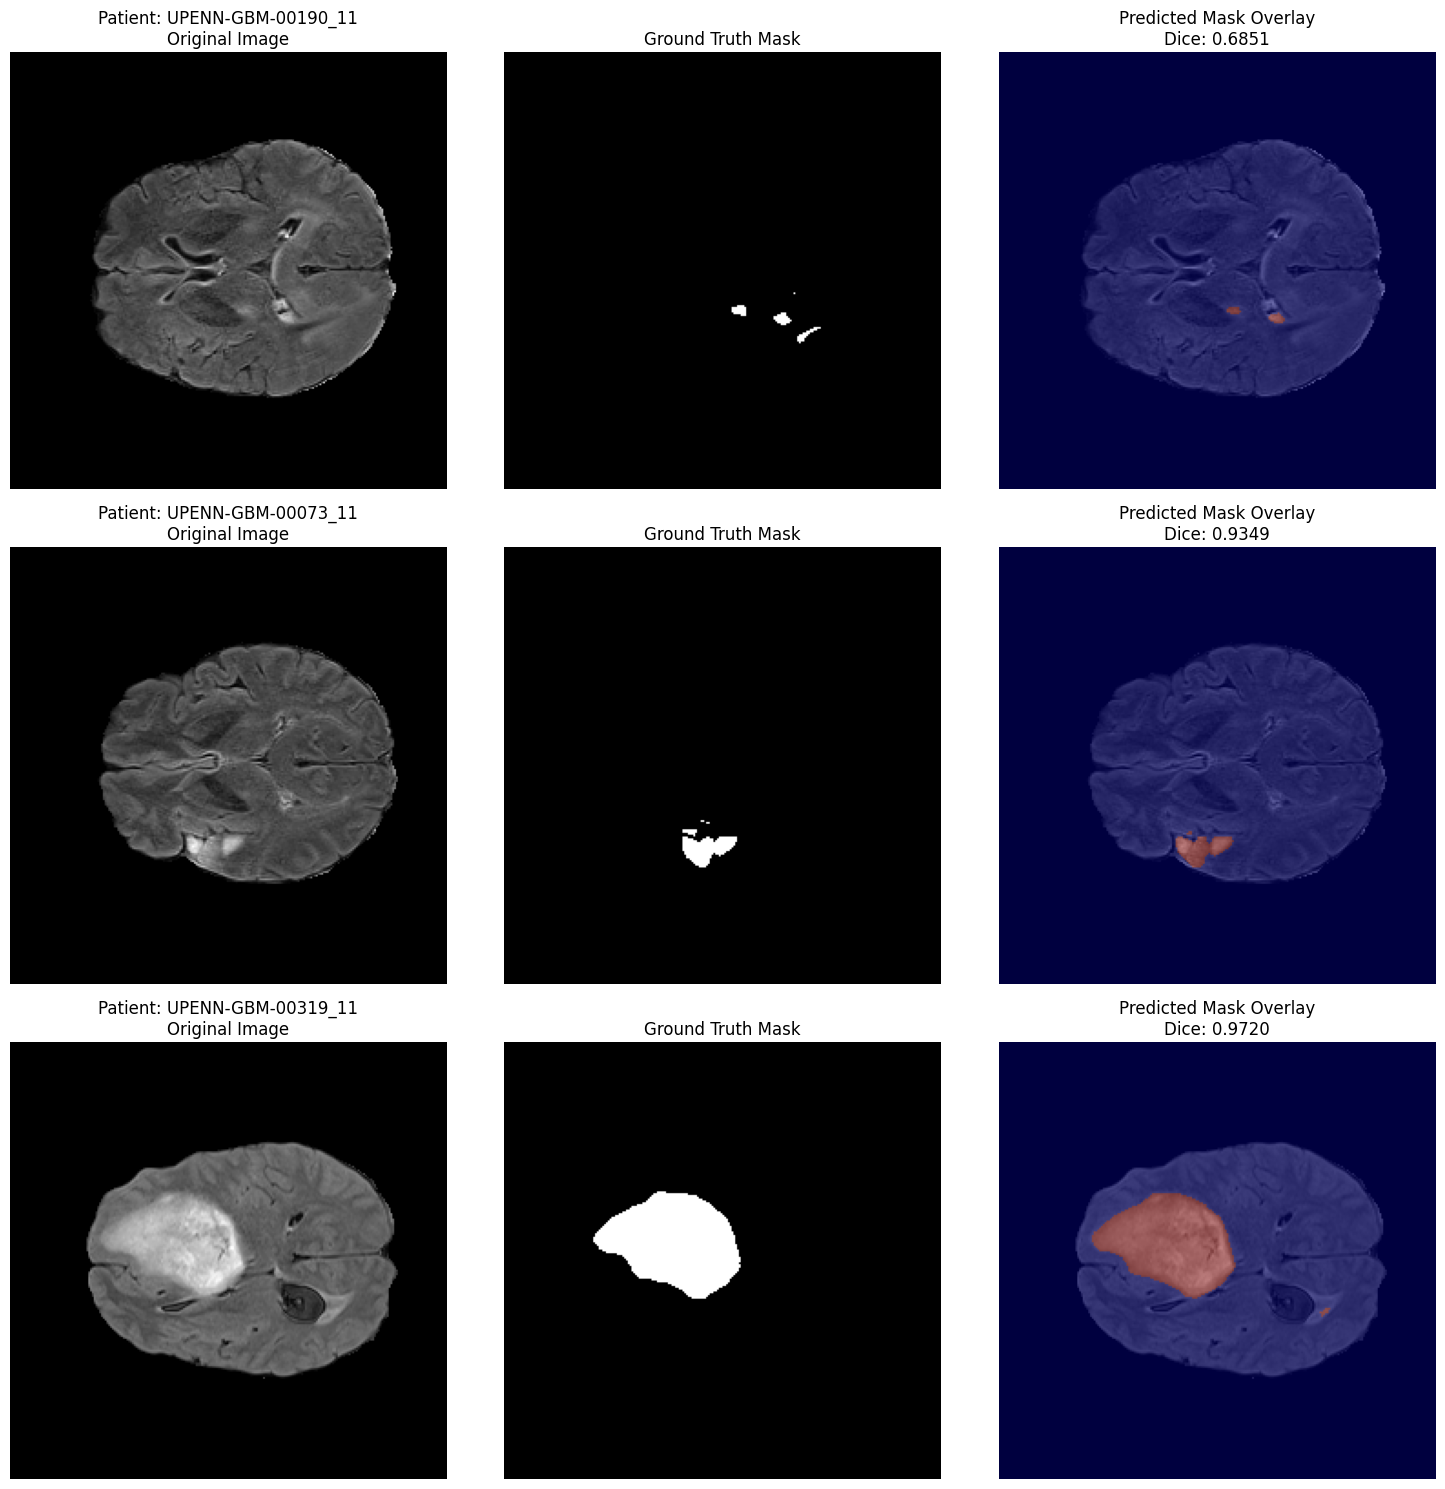

In [ ]:
# Create subplots: 3 columns (Original, Ground Truth, Prediction) per patient
fig, axs = plt.subplots(len(selected_patients), 3, figsize=(15, 5 * len(selected_patients)))

for i, patient_id in enumerate(selected_patients):
    norm_image, gt_mask, pred_mask = run_inference(best_model, patient_id, images_dir, segs_dir, modality='FLAIR', slice_index='middle')
    
    # Compute Dice score using numpy function
    dice = dice_score_numpy(pred_mask, gt_mask)
    
    # Plot original normalized image
    axs[i, 0].imshow(norm_image, cmap='gray')
    axs[i, 0].set_title(f"Patient: {patient_id}\nOriginal Image")
    axs[i, 0].axis('off')
    
    # Plot ground truth mask
    axs[i, 1].imshow(gt_mask, cmap='gray')
    axs[i, 1].set_title("Ground Truth Mask")
    axs[i, 1].axis('off')
    
    # Plot prediction overlay with Dice score in title
    axs[i, 2].imshow(norm_image, cmap='gray')
    axs[i, 2].imshow(pred_mask, cmap='jet', alpha=0.5)
    axs[i, 2].set_title(f"Predicted Mask Overlay\nDice: {dice:.4f}")
    axs[i, 2].axis('off')

plt.tight_layout()
plt.show()

In [39]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader

def train_and_evaluate(lr=1e-4, batch_size=4, num_epochs=10):
    """
    Trains a new U-Net model using the specified learning rate and batch size,
    then evaluates the model on the validation dataset.
    
    Returns:
        avg_val_dice: Average Dice score over the validation set after training.
    """
    # Create DataLoaders using the existing train_dataset and val_dataset
    train_loader_tuned = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader_tuned = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Instantiate a new model and move it to the device
    model_tuned = UNet(in_channels=1, out_channels=1).to(device)
    
    # Define optimizer and loss function
    optimizer_tuned = optim.Adam(model_tuned.parameters(), lr=lr)
    criterion_tuned = nn.BCEWithLogitsLoss()
    
    # Training loop
    for epoch in range(num_epochs):
        model_tuned.train()
        for batch in train_loader_tuned:
            images = batch['image'].float().to(device)
            masks = batch['mask'].float().to(device)
            optimizer_tuned.zero_grad()
            outputs = model_tuned(images)
            loss = criterion_tuned(outputs, masks)
            loss.backward()
            optimizer_tuned.step()
    
    # Evaluate on the validation set using the dice_coefficient function defined earlier
    model_tuned.eval()
    total_dice = 0.0
    num_batches = 0
    with torch.no_grad():
        for batch in val_loader_tuned:
            images = batch['image'].float().to(device)
            masks = batch['mask'].float().to(device)
            outputs = model_tuned(images)
            dice = dice_coefficient(outputs, masks)  # dice_coefficient must be defined
            total_dice += dice.item()
            num_batches += 1
    avg_val_dice = total_dice / num_batches
    print(f"LR: {lr}, Batch Size: {batch_size}, Epochs: {num_epochs} -> Avg Val Dice: {avg_val_dice:.4f}")
    return avg_val_dice

# Example of trying out a few hyperparameter combinations
results = {}
for lr in [1e-4, 5e-4]:
    for bs in [4, 8]:
        avg_dice = train_and_evaluate(lr=lr, batch_size=bs, num_epochs=10)
        results[(lr, bs)] = avg_dice

print("Hyperparameter tuning results (LR, Batch Size):", results)

LR: 0.0001, Batch Size: 4, Epochs: 10 -> Avg Val Dice: 0.7354
LR: 0.0001, Batch Size: 8, Epochs: 10 -> Avg Val Dice: 0.9289
LR: 0.0005, Batch Size: 4, Epochs: 10 -> Avg Val Dice: 0.8394
LR: 0.0005, Batch Size: 8, Epochs: 10 -> Avg Val Dice: 0.8888
Hyperparameter tuning results (LR, Batch Size): {(0.0001, 4): 0.7353877828295161, (0.0001, 8): 0.9288975223898888, (0.0005, 4): 0.8393628142531533, (0.0005, 8): 0.8888114914298058}


In [40]:
from torch.utils.data import DataLoader

# Define DataLoaders with appropriate batch sizes and shuffling for training
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

print("Number of training batches:", len(train_loader))
print("Number of validation batches:", len(val_loader))
print("Number of test batches:", len(test_loader))

Number of training batches: 61
Number of validation batches: 8
Number of test batches: 8


In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer with the tuned parameters
criterion = nn.BCEWithLogitsLoss()  # For binary segmentation
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 50      # Maximum number of epochs
patience = 5         # Early stopping patience
best_val_loss = float('inf')
epochs_without_improve = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    
    # Training phase using batch size = 8
    for batch in train_loader:  # train_loader is now set with batch_size=8
        images = batch['image'].float().to(device)
        masks = batch['mask'].float().to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:  # Validation loader with batch_size=8 as well
            images = batch['image'].float().to(device)
            masks = batch['mask'].float().to(device)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    
    # Check for improvement
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        model_save_path = "/home/ec2-user/BraTS_ML_Project/models/best_model.pth"
        torch.save(model.state_dict(), model_save_path)
        print("Validation loss improved, saving model.")
        epochs_without_improve = 0
    else:
        epochs_without_improve += 1
        print(f"No improvement for {epochs_without_improve} epoch(s).")
    
    if epochs_without_improve >= patience:
        print("Early stopping triggered!")
        break

Epoch [1/50] | Train Loss: 0.0068 | Val Loss: 0.0069
Validation loss improved, saving model.
Epoch [2/50] | Train Loss: 0.0066 | Val Loss: 0.0106
No improvement for 1 epoch(s).
Epoch [3/50] | Train Loss: 0.0069 | Val Loss: 0.0070
No improvement for 2 epoch(s).
Epoch [4/50] | Train Loss: 0.0058 | Val Loss: 0.0065
Validation loss improved, saving model.
Epoch [5/50] | Train Loss: 0.0054 | Val Loss: 0.0071
No improvement for 1 epoch(s).
Epoch [6/50] | Train Loss: 0.0052 | Val Loss: 0.0071
No improvement for 2 epoch(s).
Epoch [7/50] | Train Loss: 0.0052 | Val Loss: 0.0079
No improvement for 3 epoch(s).
Epoch [8/50] | Train Loss: 0.0055 | Val Loss: 0.0072
No improvement for 4 epoch(s).
Epoch [9/50] | Train Loss: 0.0052 | Val Loss: 0.0087
No improvement for 5 epoch(s).
Early stopping triggered!


In [42]:
final_model = UNet(in_channels=1, out_channels=1).to(device)
final_model.load_state_dict(torch.load("/home/ec2-user/BraTS_ML_Project/models/best_model.pth"))
final_model.eval()

UNet(
  (down1): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down2): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=

In [ ]:
# Manually define the list of patient IDs to test.
selected_patients = ['UPENN-GBM-00190_11', 'UPENN-GBM-00073_11', 'UPENN-GBM-00319_11']

# Define the paths to images and segmentation folders
images_dir = "/home/ec2-user/BraTS_ML_Project/data/UPenn_GBM/images"
segs_dir   = "/home/ec2-user/BraTS_ML_Project/data/UPenn_GBM/segmentations"

print("Selected patients:", selected_patients)

Selected patients: ['UPENN-GBM-00190_11', 'UPENN-GBM-00073_11', 'UPENN-GBM-00319_11']


In [44]:
import os
import nibabel as nib
import numpy as np
import torch

def run_inference(best_model, patient_id, images_dir, segs_dir, modality='FLAIR', slice_index='middle'):
    """
    Loads the FLAIR image and its segmentation mask for a given patient,
    extracts a 2D slice (default: middle slice), normalizes the image,
    and runs inference to obtain the predicted binary mask.
    
    Returns:
        norm_image: The normalized image slice (numpy array).
        gt_mask: Ground truth binary mask (numpy array).
        pred_mask: Predicted binary mask (numpy array).
    """
    # Construct file paths
    image_folder = os.path.join(images_dir, patient_id)
    seg_folder   = os.path.join(segs_dir, patient_id)
    image_file   = os.path.join(image_folder, f"{patient_id}_{modality}.nii.gz")
    seg_file     = os.path.join(seg_folder, f"{patient_id}_automated_approx_segm.nii.gz")
    
    # Load 3D volumes
    image_nii = nib.load(image_file)
    seg_nii   = nib.load(seg_file)
    image_data = image_nii.get_fdata()
    seg_data   = seg_nii.get_fdata()
    
    # Select a 2D slice (middle by default)
    slice_idx = image_data.shape[2] // 2 if slice_index == 'middle' else slice_index
    image_slice = image_data[:, :, slice_idx]
    gt_slice = seg_data[:, :, slice_idx]
    
    # Normalize the image slice to [0,1]
    norm_image = (image_slice - np.min(image_slice)) / (np.max(image_slice) - np.min(image_slice) + 1e-8)
    
    # Binarize the ground truth mask: set nonzero values to 1
    gt_mask = np.where(gt_slice > 0, 1.0, 0.0)
    
    # Prepare the image for inference: shape [1, 1, H, W]
    input_tensor = norm_image[None, None, ...]
    input_tensor = torch.tensor(input_tensor, dtype=torch.float32).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    
    best_model.eval()
    with torch.no_grad():
        output = best_model(input_tensor)
    
    # Convert logits to probabilities and binarize at threshold 0.5
    pred_probs = torch.sigmoid(output).cpu().numpy()[0, 0]
    pred_mask = (pred_probs > 0.5).astype(np.float32)
    
    return norm_image, gt_mask, pred_mask

def dice_score_numpy(pred_mask, gt_mask, smooth=1e-5):
    """
    Computes the Dice score for binary masks using numpy.
    
    Args:
        pred_mask: Predicted binary mask (numpy array).
        gt_mask: Ground truth binary mask (numpy array).
        smooth: Small constant to avoid division by zero.
    
    Returns:
        Dice score as a float.
    """
    intersection = np.sum(pred_mask * gt_mask)
    return (2.0 * intersection + smooth) / (np.sum(pred_mask) + np.sum(gt_mask) + smooth)

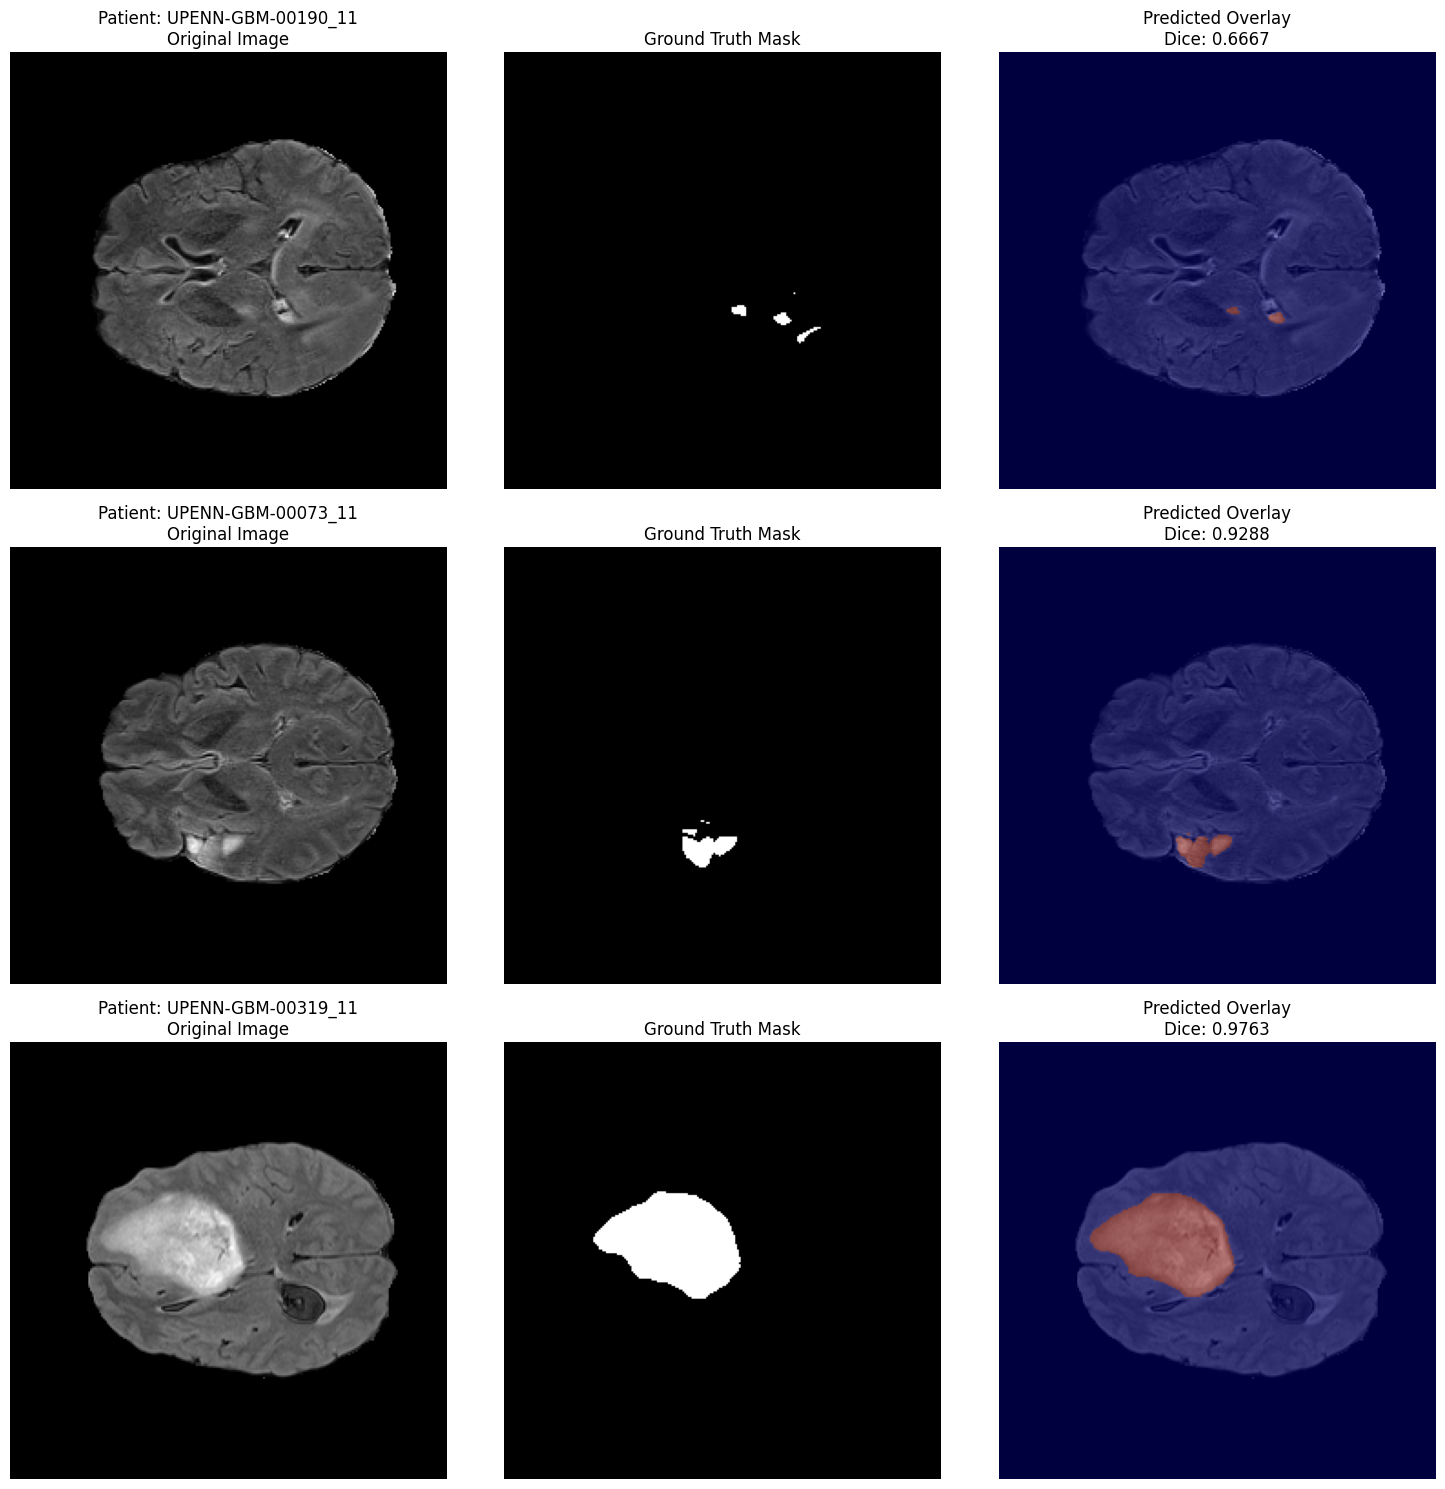

In [ ]:
import matplotlib.pyplot as plt
# Create subplots: one row per patient, three columns (Original Image, Ground Truth, Prediction Overlay)
fig, axs = plt.subplots(len(selected_patients), 3, figsize=(15, 5 * len(selected_patients)))

for i, patient_id in enumerate(selected_patients):
    norm_image, gt_mask, pred_mask = run_inference(final_model, patient_id, images_dir, segs_dir, modality='FLAIR', slice_index='middle')
    
    # Compute Dice score for this patient
    dice = dice_score_numpy(pred_mask, gt_mask)
    
    # Plot original normalized image
    axs[i, 0].imshow(norm_image, cmap='gray')
    axs[i, 0].set_title(f"Patient: {patient_id}\nOriginal Image")
    axs[i, 0].axis('off')
    
    # Plot ground truth mask
    axs[i, 1].imshow(gt_mask, cmap='gray')
    axs[i, 1].set_title("Ground Truth Mask")
    axs[i, 1].axis('off')
    
    # Plot predicted mask overlay
    axs[i, 2].imshow(norm_image, cmap='gray')
    axs[i, 2].imshow(pred_mask, cmap='jet', alpha=0.5)
    axs[i, 2].set_title(f"Predicted Overlay\nDice: {dice:.4f}")
    axs[i, 2].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
example_input = torch.randn(1, 1, 240, 240).to(device)

# Convert model to TorchScript using tracing.
traced_model = torch.jit.trace(final_model, example_input)

# Save the TorchScript model to a file.
torch.jit.save(traced_model, "/home/ec2-user/BraTS_ML_Project/models/final_model_script.pt")
print("Model has been saved as TorchScript and is ready for deployment!")

Model has been saved as TorchScript and is ready for deployment!
